## Data Preparation Notebook

## Imports

In [1]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,LabelEncoder,MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from botocore.client import Config
from ibm_watson_studio_pipelines import WSPipelines
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
import pickle
import os, types
import pandas as pd
import ibm_boto3

### Load the validated training and test data from IBM COS 

```
## PROJECT COS 
AUTH_ENDPOINT = "https://iam.cloud.ibm.com/oidc/token"
ENDPOINT_URL = "https://s3.private.us.cloud-object-storage.appdomain.cloud"
API_KEY_COS = "xxx"
BUCKET_PROJECT_COS = "mlops-donotdelete-pr-qxxcecxi1dtw94"


##MLOPS COS
ENDPOINT_URL_MLOPS = "https://s3.jp-tok.cloud-object-storage.appdomain.cloud"
API_KEY_MLOPS = "xxx"
CRN_MLOPS = "xxx"
BUCKET_MLOPS  = "mlops-asset"
```

In [2]:
# The code was removed by Watson Studio for sharing.

## Pipeline Params

In [ ]:
CLOUD_API_KEY = os.getenv("cloud_api_key")

In [3]:
project_cos_credentials = {'API_KEY':API_KEY_COS,
                          'CRN':None,
                          'AUTH_ENDPOINT':AUTH_ENDPOINT,
                           'ENDPOINT_URL':ENDPOINT_URL,
                           'BUCKET':BUCKET_PROJECT_COS
                          }

mlops_cos_credentials = {'API_KEY':API_KEY_MLOPS,
                          'CRN':CRN_MLOPS,
                          'AUTH_ENDPOINT':AUTH_ENDPOINT,
                           'ENDPOINT_URL':ENDPOINT_URL_MLOPS,
                           'BUCKET':BUCKET_MLOPS
                          }


###  Read and Write Utility

In [4]:
def read_data_from_mlops_cos(key):
    def __iter__(self): return 0
    MLOPS_DATA_STORE_client = ibm_boto3.client(
        service_name='s3',
        ibm_api_key_id=API_KEY_MLOPS,
        ibm_service_instance_id=CRN_MLOPS,
        ibm_auth_endpoint=AUTH_ENDPOINT,
        config=Config(signature_version='oauth'),
        endpoint_url=ENDPOINT_URL_MLOPS)

    body = MLOPS_DATA_STORE_client.get_object(Bucket=BUCKET_MLOPS, Key=key)['Body']
    # add missing __iter__ method, so pandas accepts body as file-like object
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

    gcf_df = pd.read_csv(body)
    return gcf_df

def save_data_in_cos(df,filename,key,credentials,pipe=False):
    """

    Save Data in IBM Cloud Object Storage

    """
    try:
        
        if pipe:
            with open (filename,'wb') as f:
                pickle.dump(pipeline,f)
        else:
            df.to_csv(filename,index=False)
        mlops_res = ibm_boto3.resource(
            service_name='s3',
            ibm_api_key_id=credentials['API_KEY'],
            ibm_auth_endpoint=credentials['AUTH_ENDPOINT'],
            config=Config(signature_version='oauth'),
            endpoint_url=credentials['ENDPOINT_URL'])

        mlops_res.Bucket(credentials['BUCKET']).upload_file(filename,key)
        print(f"File {filename} uploaded successfully")
    except Exception as e:
        print(e)
        print("File upload for {filename} failed")

        
def check_if_file_exists(filename):
    mlops_client = ibm_boto3.client(
        service_name='s3',
        ibm_api_key_id=API_KEY_MLOPS,
        ibm_service_instance_id=CRN_MLOPS,
        ibm_auth_endpoint=AUTH_ENDPOINT,
        config=Config(signature_version='oauth'),
        endpoint_url=ENDPOINT_URL_MLOPS)
    
    for key in mlops_client.list_objects(Bucket=BUCKET_MLOPS)['Contents']:
        files = key['Key']
        if files == filename:
            return True
    return False


## Train_Data 

In [5]:
train_data = read_data_from_mlops_cos('train_gcr.csv')
train_data.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,0
1,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,0
2,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,1
3,no_checking,9,prior_payments_delayed,car_new,1032,100_to_500,4_to_7,3,male,none,...,savings_insurance,41,none,own,1,management_self-employed,1,none,yes,0
4,0_to_200,11,credits_paid_to_date,car_new,4553,less_100,less_1,3,female,none,...,savings_insurance,22,none,own,1,management_self-employed,1,none,yes,0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3995 entries, 0 to 3994
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   CheckingStatus            3995 non-null   object
 1   LoanDuration              3995 non-null   int64 
 2   CreditHistory             3995 non-null   object
 3   LoanPurpose               3995 non-null   object
 4   LoanAmount                3995 non-null   int64 
 5   ExistingSavings           3995 non-null   object
 6   EmploymentDuration        3995 non-null   object
 7   InstallmentPercent        3995 non-null   int64 
 8   Sex                       3995 non-null   object
 9   OthersOnLoan              3995 non-null   object
 10  CurrentResidenceDuration  3995 non-null   int64 
 11  OwnsProperty              3995 non-null   object
 12  Age                       3995 non-null   int64 
 13  InstallmentPlans          3995 non-null   object
 14  Housing                 

In [6]:
train_data.describe()

,LoanDuration,LoanAmount,InstallmentPercent,CurrentResidenceDuration,Age,ExistingCreditsCount,Dependents,Risk
count,3995.000000,3995.000000,3995.000000,3995.00000,3995.000000,3995.000000,3995.00000,3995.000000
mean,21.395745,3488.971464,2.977222,2.84781,35.979224,1.472340,1.16821,0.330914
std,11.175001,2500.504918,1.130774,1.12105,10.678289,0.567809,0.37410,0.470601
min,4.000000,250.000000,1.000000,1.00000,19.000000,1.000000,1.00000,0.000000
25%,12.500000,1328.000000,2.000000,2.00000,28.000000,1.000000,1.00000,0.000000
50%,21.000000,3237.000000,3.000000,3.00000,36.000000,1.000000,1.00000,0.000000
75%,29.000000,5334.500000,4.000000,4.00000,44.000000,2.000000,1.00000,1.000000
max,64.000000,11676.000000,6.000000,6.00000,74.000000,4.000000,2.00000,1.000000


In [7]:
object_df = train_data.select_dtypes('O')
object_df.head()

,CheckingStatus,CreditHistory,LoanPurpose,ExistingSavings,EmploymentDuration,Sex,OthersOnLoan,OwnsProperty,InstallmentPlans,Housing,Job,Telephone,ForeignWorker
0,less_0,credits_paid_to_date,car_new,less_100,1_to_4,female,none,savings_insurance,stores,own,skilled,none,yes
1,less_0,prior_payments_delayed,furniture,less_100,1_to_4,male,none,real_estate,none,own,skilled,yes,no
2,no_checking,prior_payments_delayed,education,500_to_1000,greater_7,male,none,unknown,none,own,skilled,none,yes
3,no_checking,prior_payments_delayed,car_new,100_to_500,4_to_7,male,none,savings_insurance,none,own,management_self-employed,none,yes
4,0_to_200,credits_paid_to_date,car_new,less_100,less_1,female,none,savings_insurance,none,own,management_self-employed,none,yes


In [8]:
object_cols = list(set(object_df.columns.tolist()) - set(['Risk']))
object_cols

['LoanPurpose',
 'OthersOnLoan',
 'OwnsProperty',
 'Housing',
 'Telephone',
 'CreditHistory',
 'EmploymentDuration',
 'Sex',
 'Job',
 'ExistingSavings',
 'InstallmentPlans',
 'CheckingStatus',
 'ForeignWorker']

In [9]:
numerical_columns = [col for col in train_data.columns.tolist() if col not in object_cols and col!='Risk']

## Load Test Data 

In [10]:
test_data = read_data_from_mlops_cos('test_gcr.csv')
test_data.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,0
1,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,0
2,no_checking,32,outstanding_credit,vacation,9604,500_to_1000,greater_7,6,male,co-applicant,...,unknown,57,none,free,2,skilled,2,yes,yes,1
3,less_0,16,credits_paid_to_date,vacation,3109,less_100,4_to_7,3,female,none,...,car_other,36,none,own,2,skilled,1,none,yes,0
4,0_to_200,15,prior_payments_delayed,furniture,250,500_to_1000,4_to_7,3,male,none,...,savings_insurance,24,none,own,2,skilled,2,yes,yes,0


## Split X and Y 

In [11]:
y_train = train_data['Risk']

X_train = train_data.drop("Risk",axis=1)


y_test = test_data['Risk']

X_test = test_data.drop("Risk",axis=1)



## Categorcial Feature Analysis 

In [35]:
def prepare_input_data(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc


def prepare_output_data(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc


def select_best_chi2_features(X_train, y_train, X_test,score_func=chi2):
    featureselector = SelectKBest(score_func=chi2, k='all')
    featureselector.fit(X_train, y_train)
    X_train_best_feat = featureselector.transform(X_train)
    X_test_best_feat= featureselector.transform(X_test)
    return X_train_best_feat, X_test_best_feat, featureselector


def select_best_mutualinf_features(X_train, y_train, X_test,k=5):
    featureselector = SelectKBest(score_func=mutual_info_classif, k=k)
    featureselector.fit(X_train, y_train)
    X_train_best_feat = fs.transform(X_train)
    X_test_best_feat= fs.transform(X_test)
    return X_train_best_feat, X_test_best_feat, featureselector

def plot_scores():
    plt.figure(figsize=(14, 12))
    plt.subplot(221)

    ax1 = sns.barplot([i for i in range(len(fs.scores_))], fs.scores_)
    ax1.set_title("Chi2 Importance Scores", fontsize=20)
    ax1.set_xlabel("Features",fontsize=15)
    ax1.set_ylabel("Chi2 Scores",fontsize=15)
    
    
def get_top_k_catgeorical(fs,train_cat,k=10):
    fs_score_map = {}
    for i in range(len(fs.scores_)):
        #print(f"Feature {train_cat.columns.tolist()[i]} {fs.scores_[i]}")
        fs_score_map[train_cat.columns.tolist()[i]] = fs.scores_[i]
        
    k_keys_sorted_by_values = heapq.nlargest(k, fs_score_map, key=fs_score_map.get)
    
    return k_keys_sorted_by_values
    
    


## Encode and shape the Variables 

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


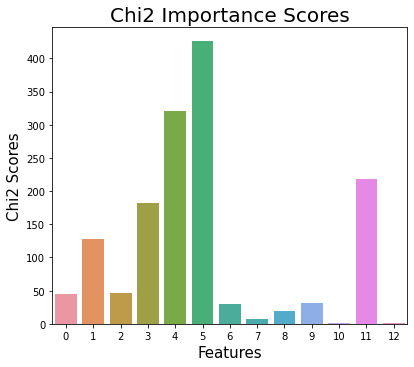

In [36]:
X_train_enc, X_test_enc = prepare_input_data(X_train[object_cols], X_test[object_cols])

y_train_enc, y_test_enc = prepare_output_data(y_train, y_test)

X_train_fs, X_test_fs, fs = select_best_chi2_features(X_train_enc, y_train_enc, X_test_enc)

plot_scores()


## Top K Categorical Features  based on Chi2

In [37]:
top_k_cat = get_top_k_catgeorical(fs,X_train[object_cols])
top_k_cat

['CreditHistory',
 'Telephone',
 'CheckingStatus',
 'Housing',
 'OthersOnLoan',
 'OwnsProperty',
 'LoanPurpose',
 'ExistingSavings',
 'EmploymentDuration',
 'Job']

## Top K Categorical Features  based on Mutual Information Feature Selection

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


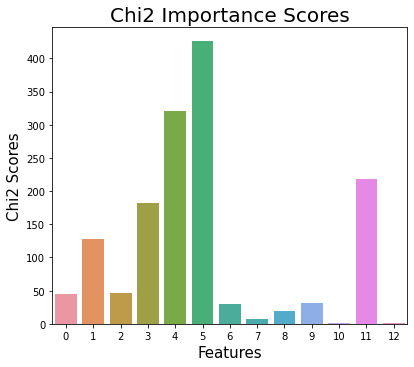

In [38]:
X_train_enc_mf, X_test_enc_mf = prepare_input_data(X_train[object_cols], X_test[object_cols])

y_train_enc_mf, y_test_enc_mf = prepare_output_data(y_train, y_test)

X_train_fs_mf, X_test_fs_mf, fs_mf = select_best_chi2_features(X_train_enc_mf, y_train_enc_mf, X_test_enc_mf)

plot_scores()

In [39]:
top_k_cat_mf = get_top_k_catgeorical(fs_mf,X_train[object_cols])
top_k_cat_mf

['CreditHistory',
 'Telephone',
 'CheckingStatus',
 'Housing',
 'OthersOnLoan',
 'OwnsProperty',
 'LoanPurpose',
 'ExistingSavings',
 'EmploymentDuration',
 'Job']

In [52]:
union_features = list(set(top_k_cat+top_k_cat_mf))
if "Sex" not in union_features:
    union_features.append("Sex")
union_features

['LoanPurpose',
 'OthersOnLoan',
 'Housing',
 'Telephone',
 'OwnsProperty',
 'CreditHistory',
 'EmploymentDuration',
 'Job',
 'ExistingSavings',
 'CheckingStatus',
 'Sex']

## Filter the Top K Categorical features and Merge to Original Train and Test Dataframes

In [53]:
X_train_object_filtered = X_train[union_features]
X_test_object_filtered = X_test[union_features]

X_train_final = pd.concat([X_train[numerical_columns],X_train_object_filtered],axis=1)

X_test_final = pd.concat([X_test[numerical_columns],X_test_object_filtered],axis=1)

## Use Column Transformer and Pipelines to encode the Input and Output Variables . Scale the Numerical columns using MinMaxScaler.

In [54]:
numerical_ix = X_train_final.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X_train_final.select_dtypes(include=['object', 'bool']).columns

In [55]:
encoding_steps = [('cat', OrdinalEncoder(), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=encoding_steps)

In [56]:
pipeline = Pipeline(steps=[('prep',col_transform)])

In [57]:
train_final = pd.concat([X_train_final,y_train],axis=1)

In [58]:
test_final = pd.concat([X_test_final,y_test],axis=1)

In [47]:
#encoded_train = pd.DataFrame(pipeline.fit_transform(X_train_final),columns=X_train_final.columns)

In [48]:
#encoded_test = pd.DataFrame(pipeline.transform(X_test_final),columns=X_test_final.columns)

## Save the Prepared Data to IBM COS

In [27]:
save_data_in_cos(train_final,"train_tfr.csv","train_tfr.csv",mlops_cos_credentials)

File train_tfr.csv uploaded successfully


In [28]:
save_data_in_cos(test_final,"test_tfr.csv","test_tfr.csv",mlops_cos_credentials)

File test_tfr.csv uploaded successfully


In [29]:
save_data_in_cos(pipeline,"feature_encode.pickle","feature_encode.pickle",mlops_cos_credentials,pipe=True)

File feature_encode.pickle uploaded successfully


## Check if files have been copied 

In [30]:
data_prep_done = check_if_file_exists("train_tfr.csv") and check_if_file_exists("test_tfr.csv") and check_if_file_exists("feature_encode.pickle")
data_prep_done

True

## Store Params in WS Pipelines

In [33]:
preparation_params = {}
preparation_params['data_prep_done'] = data_prep_done

pipelines_client = WSPipelines.from_apikey(apikey=CLOUD_API_KEY)
pipelines_client.store_results(preparation_params)

MissingValueError: No "APIKEY" provided.